[DTW]:https://en.wikipedia.org/wiki/Dynamic_time_warping
[Peng]:https://pdfs.semanticscholar.org/6f94/c8acf2e2b0a2696bbae9bc10445e01a6fb69.pdf
[Li]:https://ac.els-cdn.com/S2405896315012276/1-s2.0-S2405896315012276-main.pdf?_tid=5de6b95e-8d94-411d-8e5f-9d45fe0be009&acdnat=1548895956_18da4eeb386e005ff38c53fc57f173b8

<span style="color: red">Work under development</span>
 
 
The purpose of this notebook is to investigate the proprieties of the [Dynamic Time Warping][DTW] algorithm as a lead indicator.

The only piece of literature I found mentioning such possibility is *CDynamic time warping based causality
analysis for root-cause diagnosis of nonstationary fault processes* by [Li et al.][Li]


After playing with DTW on random data, we will implement the leading indicator that Peng and al. proposed. We will then try to research the idea further.

In [1]:
from tslearn.metrics import dtw, dtw_path
from sklearn.preprocessing import minmax_scale
from scipy import stats
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(style='white')

# DTW playground

Staring with the ability to plot what path DTW comes up with.

## Path plot

In [2]:
def z_norm(arr):
    """
    z normalize an np.array.
    arr:np.array or list-like
    return: np.array
    """
    
    return (arr-np.mean(arr)) / np.std(arr)

In [3]:
def plot_dtw_path(s1, s2, title=None):
    """
    Given two time series s1 and s2,
    
    s1: np.array or list-like
    s2: np.array or list-like
    title: title of plot
    returns: plot
    """
    path = dtw_path(s1, s2)[0]
    
    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(s1, linewidth=2.5, label='s1')
    ax.plot(s2, linewidth=2.5, label='s2')
    
    # build and plot segments
    for s1_idx, s2_idx in path:
        x = [s1_idx, s2_idx]
        y = [s1[s1_idx], s2[s2_idx]]
        ax.plot(x, y, c='r', ls='--')
        
    if title is not None:
        ax.set_title(title)
    fig.legend()
    return ax 


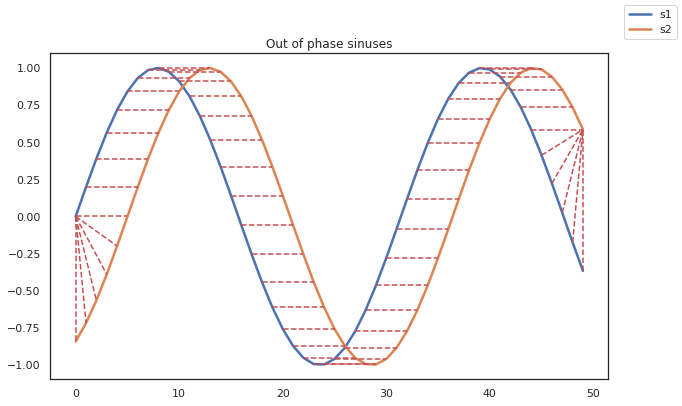

In [4]:
s1_sin = np.sin(np.arange(0, 10, 0.2))
s2_sin = np.sin(np.arange(-1, 9, 0.2))

plot_dtw_path(s1_sin, s2_sin, title='Out of phase sinuses');

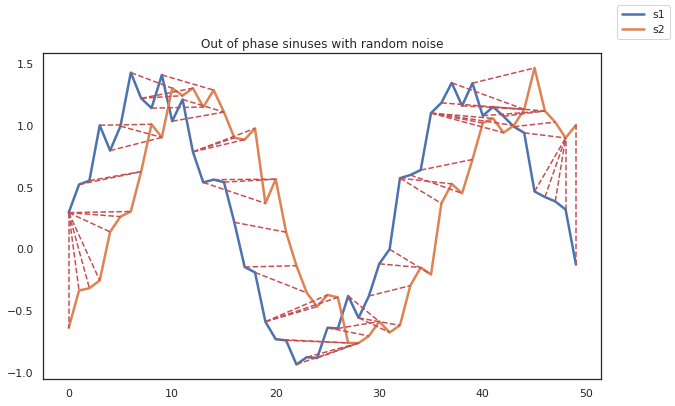

In [5]:
noise_scale = 0.5
n = 50
s1_sin = np.sin(np.arange(0, 10, 10/n)) + noise_scale * np.random.rand(n) 
s2_sin = np.sin(np.arange(-1, 9, 10/n)) + noise_scale * np.random.rand(n)

plot_dtw_path(s1_sin, s2_sin, title='Out of phase sinuses with random noise');

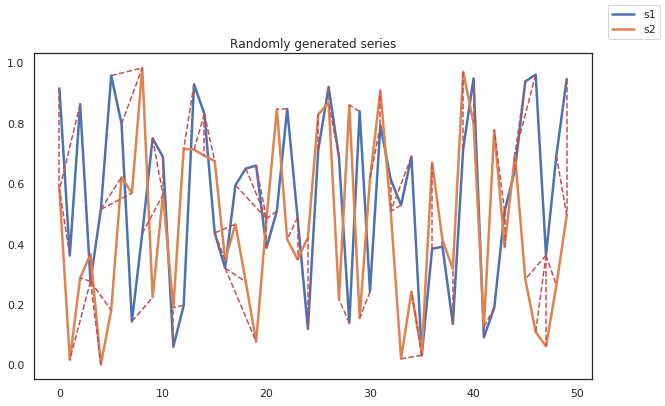

In [6]:
n = 50
s1_nrand = np.random.rand(n)
s2_nrand = np.random.rand(n)
plot_dtw_path(s1_nrand, s2_nrand, title='Randomly generated series');

## Monte Carlo

What happens when we calculate DTW on thousands of series of random data?

In [7]:
n = 50
n_simulation = 10000
dtws_norm = []
dtws_unif = []
for i in tqdm(range(n_simulation)):  # Very multithread-able
    s1_norm = z_norm(np.random.rand(n))
    s2_norm = z_norm(np.random.rand(n))
    dtws_norm.append(dtw(s1_norm, s2_norm))
    
    s1_unif = z_norm(np.random.uniform(size=n))
    s2_unif = z_norm(np.random.uniform(size=n))
    dtws_unif.append(dtw(s1_unif, s2_unif))

100%|██████████| 10000/10000 [00:38<00:00, 261.32it/s]


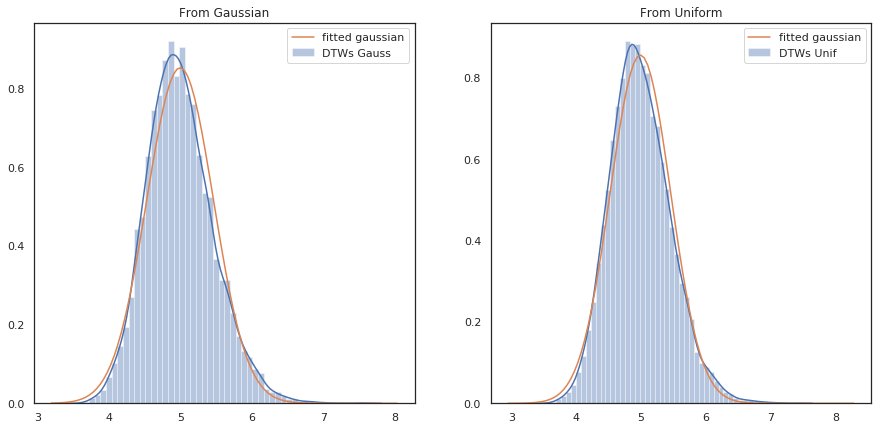

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

# Gaussian
ax1.set_title('From Gaussian')
sns.distplot(dtws_norm, label='DTWs Gauss', bins=50, ax=ax1)
# Let's fit a gaussian on this
xmin, xmax = ax1.get_xlim()
x = np.linspace(xmin, xmax, 100)
mu, std = stats.norm.fit(dtws_norm)
gauss = stats.norm.pdf(x, mu, std)
sns.lineplot(x, gauss, label='fitted gaussian', ax=ax1);

# Uniform
ax2.set_title('From Uniform')
sns.distplot(dtws_unif, label='DTWs Unif', bins=50, ax=ax2)
xmin, xmax = ax1.get_xlim()
x = np.linspace(xmin, xmax, 100)
mu, std = stats.norm.fit(dtws_unif)
gauss = stats.norm.pdf(x, mu, std)
sns.lineplot(x, gauss, label='fitted gaussian', ax=ax2);

The above distribution is not exactly gaussian.

The average DTW should probably be a function of *n*, the length of the input series. What does that function look like?

In [9]:
n_max = 100
n_simulation = 500
dtws_avg = []
for length in tqdm(range(10, n_max)):
    dtws = []
    for _ in range(n_simulation):
        s1 = z_norm(np.random.rand(length))
        s2 = z_norm(np.random.rand(length))
        dtws.append(dtw(s1, s2))
    dtws_avg.append(np.mean(dtws))

100%|██████████| 90/90 [02:00<00:00,  3.28s/it]


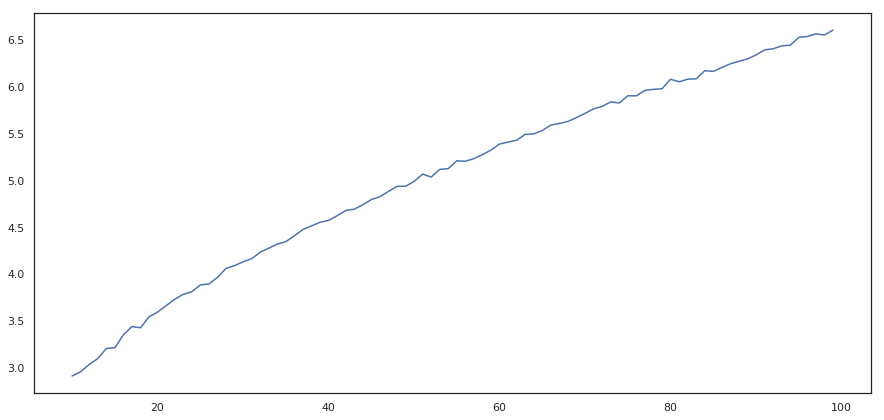

In [10]:
fig, ax = plt.subplots(figsize=(15,7))
sns.lineplot(np.arange(10, n_max), dtws_avg, ax=ax);

DTW seems to increase linearly with the series length.


# Li et al.

First, let us transcribe their algorithm here. It is fairly simple, and I encourage all readers to take a look at the original paper. The algorithm is presented on in 3.1.

Following their nomenclature, let us call $x_i$ and $x_j$ the two series we are working with. The first thing to 
do is to MinMax scale the series between 0 and 1.  
We then create the following function:
$$D_{ij} (w) = DTW(x_i(1 : n − w), x_j (w + 1 : n))$$

To be able to compare D with different w, and thus different lengths of subsets of $x_i$ and $x_j$, all DTW values are divided by the length of the longer series.

From D, we create the *DTW based causality index* (DCI):
$$DCI_{ij} = \frac{min D_{ij}(w)}{D_{ij}(0)}$$

The authors write *"$DCI_{ij}$ measures whether a pattern appears earlier in x_i
than in x_j , i.e. whether x_i precedes x_j"*. While there is some truth in that statement, DCI does not seem flexible enough to match similar patterns in the series. $D_{ij}(w)$ chips away $w$ of the first values of $x_i$ and $w$ of the last values of $x_j$. What happens if the similar patterns appear exactly at the beggining of $x_i$ ad end of $x_j$?

Anyways, Li et al. continue to say: 
*" [...] if $DCI_{ij} < \alpha$, it can be concluded that there is a significant
causality from $x_i$ to $x_j$ , where $\alpha$is the significance level.
If $DCI_{ij} ≥ \alpha$, it indicates the two series are causal to
each other."*

We now implement Li et al.'s algorithm.

In [11]:
def D(s1, s2, w):
    
    """
    as defined byt Li et al.
    
    s1, s2: np.arr or list-like
    w: int, window
    returns: float, scaled dtw of truncated series 
    """
    
    s1_head = s1[:len(s1)-w]
    s2_tail = s2[w:]
    d = dtw(s1_head, s2_tail)
    d /= max(len(s1_head), len(s2_tail))
    
    return d

In [12]:
def DCI(s1, s2, w_max=None):
    """
    as defined by Li et al.
    
    s1, s2: np.arr or list-like
    w_max: int, max window
    returns: float, the DCI
    """
    if w_max is None:
        w_max = min(len(s1), len(s2))
    else:
        assert  w_max < min(len(s1), len(s2)),  "w_max too big"
        
    s1 = minmax_scale(s1)
    s2 = minmax_scale(s2)
        
    D_0 = D(s1, s2, w=0)
    
    min_D = D_0
    for w in range(1, w_max):
        d = D(s1, s2, w)
        if d < min_D:
            min_D = d
            
    return min_D / D_0

Li et al note themselves in their paper:  
***"Notice that if two series are not similar in the
shape, it is not proper to use this index for indicating the
causality."***

Let us see what DCI yields on actually ,

In [13]:
def create_lagged(s1, lag, noise_scale=0):
    """
    create a lagged version of a series
    
    s1: np.arr
    noise_scale : float
    return (np.arr, np.arr)
    """
    ln = len(s1) - lag
    s2 = s1[lag:] + noise_scale * np.random.rand(ln)
    s1 = s1[:-lag] + noise_scale * np.random.rand(ln)
    
    return s1,s2

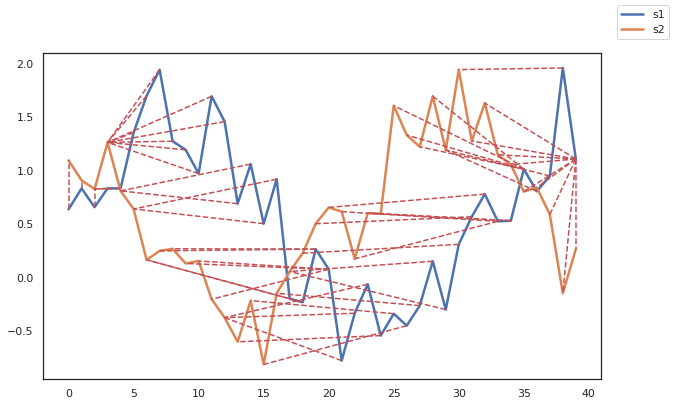

In [14]:
s1_sin = np.sin(np.arange(0, 10, 0.2))
s1, s2 = create_lagged(s1_sin, 10,1)
plot_dtw_path(s1, s2)

In [15]:
n = 50
n_simulation = 1000
lag = 15
dcis_low_noise = []
dcis_med_noise = []
dcis_hi_noise = []
dci_random = []

for _ in tqdm(range(n_simulation)): 
    s1_sin = np.sin(np.arange(0, 10, 0.2))
    
    s1_low_noise, s2_low_noise = create_lagged(s1_sin, lag=lag, noise_scale=0.1)
    s1_med_noise, s2_med_noise = create_lagged(s1_sin, lag=lag, noise_scale=1)
    s1_hi_noise, s2_hi_noise = create_lagged(s1_sin, lag=lag, noise_scale=2.5)
    s1_rand = np.random.rand(n)
    s2_rand = np.random.rand(n)
    
    dcis_low_noise.append(DCI(s1_low_noise, s2_low_noise))
    dcis_med_noise.append(DCI(s1_med_noise, s2_med_noise))
    dcis_hi_noise.append(DCI(s1_hi_noise, s2_hi_noise))
    dci_random.append(DCI(s1_rand, s2_rand))

100%|██████████| 1000/1000 [01:12<00:00, 13.83it/s]


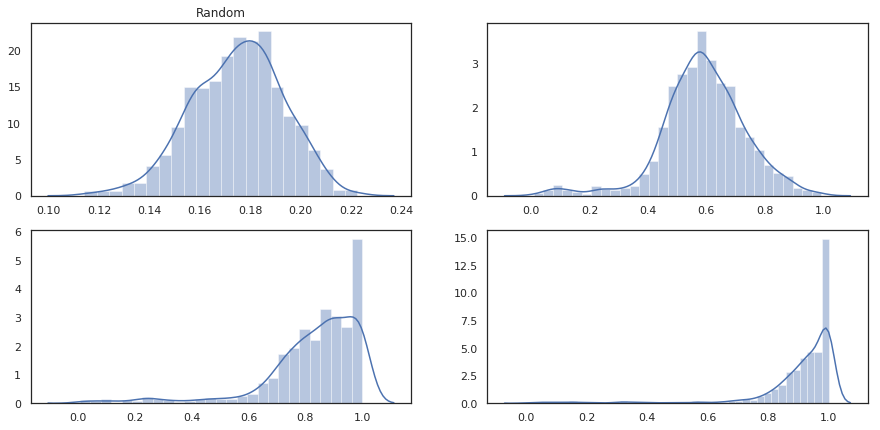

In [19]:
fig, ax = plt.subplots(2, 2, figsize=(15,7))
sns.distplot(dcis_low_noise, ax=ax[0,0])
ax[0,0].set_title('Low noise')
sns.distplot(dcis_med_noise, ax=ax[0,1])
ax[0,0].set_title('Medium noise')
sns.distplot(dcis_hi_noise, ax=ax[1,0])
ax[0,0].set_title('High noise')
sns.distplot(dci_random, ax=ax[1,1])
ax[0,0].set_title('Random');